In [1]:
import argparse
from tqdm import tqdm, trange
from torch.optim import Adam
from torch_geometric.data import Data, HeteroData

import numpy as np
import torch
import torch.nn as nn
from torchmetrics.regression import MeanAbsolutePercentageError

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from torch_geometric.transforms import ToSparseTensor, VirtualNode, ToUndirected
from torch_geometric.nn import to_hetero
from transforms import add_laplace_positional_encoding, add_virtual_node
import yaml
import os
import csv

mse_loss = nn.MSELoss()
relu = nn.ReLU()
softplus = nn.Softplus()

/home/sam/anaconda3/envs/graphgps/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, GINConv, GATConv, GCN2Conv, TransformerConv, to_hetero
from torch.nn import ReLU, LeakyReLU, Sigmoid

# Baseline 0
def initialize_mlp(input, hidden, output, layers, batch_norm=False, activation='lrelu'):
    if layers == 1:
        hidden=output
    if activation == 'relu':
        func = nn.ReLU
    elif activation =='lrelu':
        func = nn.LeakyReLU
    elif activation=='sigmoid':
        func = nn.Sigmoid
    elif activation =='softplus':
        func = nn.Softplus
    else:
        raise NameError('Not implemented')

    phi_layers= []
    phi_layers.append(nn.Linear(input, hidden))
    phi_layers.append(func())
    if batch_norm:
        phi_layers.append(nn.BatchNorm1d(input))
    for i in range(layers - 1):
        if i < layers - 2:
            phi_layers.append(nn.Dropout(p=0.10))
            phi_layers.append(nn.Linear(hidden, hidden))
            phi_layers.append(func())
            if batch_norm:
                phi_layers.append(nn.BatchNorm1d(hidden))
        else:
            phi_layers.append(nn.Linear(hidden, output))

    phi = nn.Sequential(*phi_layers)
    return phi

class MLPBaseline0(nn.Module):
    def __init__(self, siamese: nn.Module, final: nn.Module, max=True):
        super(MLPBaseline0, self).__init__()
        self.siamese = siamese
        self.final = final
        self.max = max
    
    def init_weights(self):
        for m in self.siamese:
            if isinstance(m, nn.Linear):
                torch.nn.init.constant_(m.weight, 0.01)
                torch.nn.init.constant_(m.bias, 0.01)
        for m in self.final:
            if isinstance(m, nn.Linear):
                torch.nn.init.constant_(m.weight, 0.01)
                torch.nn.init.constant_(m.bias, 0.01)
    
    def forward(self, input1, input2):
        out1 = input1
        out2 = input2
        if not self.max:
            embd = out1 + out2
        else:
            embd = torch.max(out1, out2)
        return self.final(embd)
class MLPBaseline1(nn.Module):
    def __init__(self, mlp: nn.Module, max=True):
        super(MLPBaseline1, self).__init__()
        self.max = max
        self.mlp = mlp
    
    def init_weights(self):
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                torch.nn.init.constant_(m.weight, 0.01)
                torch.nn.init.constant_(m.bias, 0.01)
    
    def forward(self, input1, input2):
        if not self.max:
            embd = input1 + input2
        else:
            embd = torch.max(input1, input2)
        return self.mlp(embd)

class GINLayer(nn.Module):
    def __init__(self, input=3, output=20, eps=0.001):
        super(GINLayer, self).__init__()
        self.nn = nn.Sequential(nn.Linear(input, output), 
                                nn.ReLU(),
                                nn.Linear(output, output))
        self.layer = GINConv(self.nn, eps=0.001)

    def forward(self, x, edge_index):
        output = self.layer(x, edge_index)
        return output


class GNNModel(nn.Module):
    def __init__(self, input=3, output=20, hidden=20, layers=2, 
                 layer_type='GATConv', activation='LeakyReLU', **kwargs):
        super(GNNModel, self).__init__()
        torch.manual_seed(1234567)
        # Initialize the first layer
        graph_layer = globals()[layer_type]
        self.initial = graph_layer(input, hidden)
        
        # Initialize the subsequent layers
        self.module_list = nn.ModuleList([graph_layer(hidden, hidden) for _ in range(layers - 1)])
        
        # Output layer
        self.output = graph_layer(hidden, output)

        # activation function
        self.activation = globals()[activation]()

    def forward(self, x, edge_index):
        x = self.initial(x, edge_index)
        x = self.activation(x)
        for layer in self.module_list:
            x = layer(x, edge_index)
            x = self.activation(x)
        x = self.output(x, edge_index)
        return x

In [9]:
import matplotlib.pyplot as plt

class SingleGraphShortestPathDataset(Dataset):
    def __init__(self, sources, targets, lengths):
        self.sources = sources
        self.targets = targets
        self.lengths = lengths

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        return self.sources[idx], self.targets[idx], self.lengths[idx]

def custom_loss(pred, target):
    errs = torch.square(pred - target)/torch.square(target)
    return torch.mean(errs)
    
def compute_validation_loss(node_embeddings, dataloader, mlp=None, device='cuda:0'):
    total = 0
    count = 0
    for batch in dataloader:
        srcs = batch[0].to(device)
        tars = batch[1].to(device)
        lengths = batch[2].to(device)
        if mlp == None:
            pred = torch.norm(node_embeddings[srcs] - node_embeddings[tars], p=2, dim=1)
        else: 
            pred = mlp(node_embeddings[srcs], node_embeddings[tars])
            pred = pred.squeeze()
        nz = torch.nonzero(lengths)
        relative_losses = torch.sum(torch.abs(pred[nz] - lengths[nz])/lengths[nz])
        total += relative_losses.detach()
        count += len(srcs)

    return total/count

def npz_to_dataset(data):
    
    edge_index = torch.tensor(data['edge_index'], dtype=torch.long)

    srcs = torch.tensor(data['srcs'])
    tars = torch.tensor(data['tars'])
    lengths = torch.tensor(data['lengths'])
   
    # normalized_lengths = (lengths - torch.min(lengths))/(torch.max(lengths) - torch.min(lengths))
    # lengths = normalized_lengths
    node_features = torch.tensor(data['node_features'], dtype=torch.double)

    train_dataset = SingleGraphShortestPathDataset(srcs, tars, lengths)

    return train_dataset, node_features, edge_index

# Training loop
def train_single_graph_baseline1(node_features, edge_index, train_dataloader, 
                                 test_node_features, test_edge_index, test_dataloader, 
                                 model_config, epochs=100, device='cuda:0', lr=0.001, 
                                 siamese=True, virtual_node=False):
    
    # initiate summary writer
    
    gnn_config = model_config['gnn']
    graph_data = Data(x=node_features, edge_index=edge_index)
    test_graph = Data(x=test_node_features, edge_index=test_edge_index)
    
    print("Train GNN")
    gnn_model = GNNModel(**gnn_config)
            
    gnn_model = gnn_model.to(torch.double)

    mlp=None

    gnn_model.to(device)
    if siamese:
        parameters = gnn_model.parameters()
    else:
        phi_config = model_config['phi']
        phi = initialize_mlp(**phi_config)
        final_config = model_config['mlp']
        final = initialize_mlp(**final_config)
        mlp = MLPBaseline1(final)
        mlp.init_weights()
        mlp = mlp.to(torch.double)
        mlp.to(device)

        parameters = list(gnn_model.parameters()) + list(mlp.parameters())
    
    optimizer = Adam(parameters, lr=lr)

    val_set_losses = []
    train_set_losses = []

    for epoch in trange(epochs):
        total_loss = 0
        batch_count = 0
        for batch in train_dataloader:
            batch_count += 1

            optimizer.zero_grad()
            
            srcs = batch[0].to(device)
            tars = batch[1].to(device)
            lengths = batch[2].to(device)
            graph_data = graph_data.to(device)
            # node_features = node_features.to(device)
            
            # edge_index = edge_index.to(device)
            node_embeddings = gnn_model(graph_data.x, graph_data.edge_index)
            if siamese:
                pred = torch.norm(node_embeddings[srcs] - node_embeddings[tars], p=2, dim=1)
            else:
                pred = mlp(node_embeddings[srcs], node_embeddings[tars])
                pred = pred.squeeze()

            #loss = mse_loss(torch.log(1 + pred), torch.log(1 + lengths))
            #loss = mse_loss(pred, lengths)/torch.sum(1/lengths**2)
            loss = custom_loss(pred, lengths)
            total_loss += loss.detach()
            loss.backward()
            optimizer.step()
            batch_count += 1

        test_graph = test_graph.to(device)
        node_embeddings = gnn_model(graph_data.x, graph_data.edge_index)

        val_loss = compute_validation_loss(node_embeddings, test_dataloader, mlp=mlp, device=device)
        val_set_losses.append(val_loss.detach().cpu().numpy())

        train_relative_loss = compute_validation_loss(node_embeddings, train_dataloader, mlp=mlp, device=device)
        train_set_losses.append(train_relative_loss.detach().cpu().numpy())
        
        if epoch == epochs - 1:
            print(pred)
            print(lengths)
        print("epoch:", epoch, "test loss (relative error):", val_loss)
        print("epoch:", epoch, "train loss (relative error):", train_relative_loss)
        print("Total loss:", total_loss/batch_count)

    plt.plot(np.arange(epochs), val_set_losses, label="validation set relative losses, siam" if siamese else "validation set relative losses, mlp")
    plt.plot(np.arange(epochs), train_set_losses, label="train set relative losses, siam" if siamese else "train set relative losses, mlp")
    plt.legend()
    return gnn_model
    



Train GNN


  1%|          | 1/100 [00:01<02:11,  1.33s/it]

epoch: 0 test loss (relative error): tensor(0.6780, device='cuda:6', dtype=torch.float64)
epoch: 0 train loss (relative error): tensor(0.6298, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.3662, device='cuda:6', dtype=torch.float64)


  2%|▏         | 2/100 [00:02<02:04,  1.27s/it]

epoch: 1 test loss (relative error): tensor(0.6721, device='cuda:6', dtype=torch.float64)
epoch: 1 train loss (relative error): tensor(0.6226, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.2536, device='cuda:6', dtype=torch.float64)


  3%|▎         | 3/100 [00:03<01:58,  1.23s/it]

epoch: 2 test loss (relative error): tensor(0.6665, device='cuda:6', dtype=torch.float64)
epoch: 2 train loss (relative error): tensor(0.6173, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.2495, device='cuda:6', dtype=torch.float64)


  4%|▍         | 4/100 [00:05<01:59,  1.24s/it]

epoch: 3 test loss (relative error): tensor(0.6579, device='cuda:6', dtype=torch.float64)
epoch: 3 train loss (relative error): tensor(0.6098, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.2442, device='cuda:6', dtype=torch.float64)


  5%|▌         | 5/100 [00:06<02:00,  1.27s/it]

epoch: 4 test loss (relative error): tensor(0.6437, device='cuda:6', dtype=torch.float64)
epoch: 4 train loss (relative error): tensor(0.5973, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.2359, device='cuda:6', dtype=torch.float64)


  6%|▌         | 6/100 [00:07<02:02,  1.30s/it]

epoch: 5 test loss (relative error): tensor(0.6219, device='cuda:6', dtype=torch.float64)
epoch: 5 train loss (relative error): tensor(0.5783, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.2235, device='cuda:6', dtype=torch.float64)


  7%|▋         | 7/100 [00:08<02:00,  1.30s/it]

epoch: 6 test loss (relative error): tensor(0.5878, device='cuda:6', dtype=torch.float64)
epoch: 6 train loss (relative error): tensor(0.5482, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.2048, device='cuda:6', dtype=torch.float64)


  8%|▊         | 8/100 [00:10<02:00,  1.31s/it]

epoch: 7 test loss (relative error): tensor(0.5355, device='cuda:6', dtype=torch.float64)
epoch: 7 train loss (relative error): tensor(0.5019, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.1782, device='cuda:6', dtype=torch.float64)


  9%|▉         | 9/100 [00:11<01:59,  1.31s/it]

epoch: 8 test loss (relative error): tensor(0.4553, device='cuda:6', dtype=torch.float64)
epoch: 8 train loss (relative error): tensor(0.4313, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.1415, device='cuda:6', dtype=torch.float64)


 10%|█         | 10/100 [00:12<01:58,  1.32s/it]

epoch: 9 test loss (relative error): tensor(0.3449, device='cuda:6', dtype=torch.float64)
epoch: 9 train loss (relative error): tensor(0.3309, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0960, device='cuda:6', dtype=torch.float64)


 11%|█         | 11/100 [00:14<01:55,  1.30s/it]

epoch: 10 test loss (relative error): tensor(0.2207, device='cuda:6', dtype=torch.float64)
epoch: 10 train loss (relative error): tensor(0.2112, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0524, device='cuda:6', dtype=torch.float64)


 12%|█▏        | 12/100 [00:15<01:53,  1.29s/it]

epoch: 11 test loss (relative error): tensor(0.1460, device='cuda:6', dtype=torch.float64)
epoch: 11 train loss (relative error): tensor(0.1394, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0246, device='cuda:6', dtype=torch.float64)


 13%|█▎        | 13/100 [00:16<01:50,  1.27s/it]

epoch: 12 test loss (relative error): tensor(0.1119, device='cuda:6', dtype=torch.float64)
epoch: 12 train loss (relative error): tensor(0.1106, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0131, device='cuda:6', dtype=torch.float64)


 14%|█▍        | 14/100 [00:18<01:51,  1.29s/it]

epoch: 13 test loss (relative error): tensor(0.0983, device='cuda:6', dtype=torch.float64)
epoch: 13 train loss (relative error): tensor(0.0961, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0085, device='cuda:6', dtype=torch.float64)


 15%|█▌        | 15/100 [00:19<01:50,  1.30s/it]

epoch: 14 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 14 train loss (relative error): tensor(0.0878, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0065, device='cuda:6', dtype=torch.float64)


 16%|█▌        | 16/100 [00:20<01:49,  1.30s/it]

epoch: 15 test loss (relative error): tensor(0.0885, device='cuda:6', dtype=torch.float64)
epoch: 15 train loss (relative error): tensor(0.0826, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0055, device='cuda:6', dtype=torch.float64)


 17%|█▋        | 17/100 [00:21<01:47,  1.30s/it]

epoch: 16 test loss (relative error): tensor(0.0847, device='cuda:6', dtype=torch.float64)
epoch: 16 train loss (relative error): tensor(0.0786, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0049, device='cuda:6', dtype=torch.float64)


 18%|█▊        | 18/100 [00:23<01:45,  1.29s/it]

epoch: 17 test loss (relative error): tensor(0.0809, device='cuda:6', dtype=torch.float64)
epoch: 17 train loss (relative error): tensor(0.0752, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0044, device='cuda:6', dtype=torch.float64)


 19%|█▉        | 19/100 [00:24<01:42,  1.27s/it]

epoch: 18 test loss (relative error): tensor(0.0772, device='cuda:6', dtype=torch.float64)
epoch: 18 train loss (relative error): tensor(0.0720, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0040, device='cuda:6', dtype=torch.float64)


 20%|██        | 20/100 [00:25<01:43,  1.29s/it]

epoch: 19 test loss (relative error): tensor(0.0737, device='cuda:6', dtype=torch.float64)
epoch: 19 train loss (relative error): tensor(0.0689, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0037, device='cuda:6', dtype=torch.float64)


 21%|██        | 21/100 [00:27<01:43,  1.31s/it]

epoch: 20 test loss (relative error): tensor(0.0702, device='cuda:6', dtype=torch.float64)
epoch: 20 train loss (relative error): tensor(0.0660, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0034, device='cuda:6', dtype=torch.float64)


 22%|██▏       | 22/100 [00:28<01:40,  1.29s/it]

epoch: 21 test loss (relative error): tensor(0.0669, device='cuda:6', dtype=torch.float64)
epoch: 21 train loss (relative error): tensor(0.0633, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0031, device='cuda:6', dtype=torch.float64)


 23%|██▎       | 23/100 [00:29<01:39,  1.30s/it]

epoch: 22 test loss (relative error): tensor(0.0637, device='cuda:6', dtype=torch.float64)
epoch: 22 train loss (relative error): tensor(0.0606, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0029, device='cuda:6', dtype=torch.float64)


 24%|██▍       | 24/100 [00:31<01:38,  1.30s/it]

epoch: 23 test loss (relative error): tensor(0.0609, device='cuda:6', dtype=torch.float64)
epoch: 23 train loss (relative error): tensor(0.0579, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0027, device='cuda:6', dtype=torch.float64)


 25%|██▌       | 25/100 [00:32<01:37,  1.31s/it]

epoch: 24 test loss (relative error): tensor(0.0583, device='cuda:6', dtype=torch.float64)
epoch: 24 train loss (relative error): tensor(0.0554, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0025, device='cuda:6', dtype=torch.float64)


 26%|██▌       | 26/100 [00:33<01:33,  1.26s/it]

epoch: 25 test loss (relative error): tensor(0.0554, device='cuda:6', dtype=torch.float64)
epoch: 25 train loss (relative error): tensor(0.0529, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0023, device='cuda:6', dtype=torch.float64)


 27%|██▋       | 27/100 [00:34<01:29,  1.23s/it]

epoch: 26 test loss (relative error): tensor(0.0538, device='cuda:6', dtype=torch.float64)
epoch: 26 train loss (relative error): tensor(0.0509, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0021, device='cuda:6', dtype=torch.float64)


 28%|██▊       | 28/100 [00:35<01:26,  1.21s/it]

epoch: 27 test loss (relative error): tensor(0.0524, device='cuda:6', dtype=torch.float64)
epoch: 27 train loss (relative error): tensor(0.0489, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0020, device='cuda:6', dtype=torch.float64)


 29%|██▉       | 29/100 [00:36<01:25,  1.20s/it]

epoch: 28 test loss (relative error): tensor(0.0518, device='cuda:6', dtype=torch.float64)
epoch: 28 train loss (relative error): tensor(0.0473, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0018, device='cuda:6', dtype=torch.float64)


 30%|███       | 30/100 [00:38<01:22,  1.18s/it]

epoch: 29 test loss (relative error): tensor(0.0494, device='cuda:6', dtype=torch.float64)
epoch: 29 train loss (relative error): tensor(0.0451, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0017, device='cuda:6', dtype=torch.float64)


 31%|███       | 31/100 [00:39<01:19,  1.16s/it]

epoch: 30 test loss (relative error): tensor(0.0486, device='cuda:6', dtype=torch.float64)
epoch: 30 train loss (relative error): tensor(0.0437, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0016, device='cuda:6', dtype=torch.float64)


 32%|███▏      | 32/100 [00:40<01:20,  1.19s/it]

epoch: 31 test loss (relative error): tensor(0.0475, device='cuda:6', dtype=torch.float64)
epoch: 31 train loss (relative error): tensor(0.0419, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0015, device='cuda:6', dtype=torch.float64)


 33%|███▎      | 33/100 [00:41<01:18,  1.16s/it]

epoch: 32 test loss (relative error): tensor(0.0463, device='cuda:6', dtype=torch.float64)
epoch: 32 train loss (relative error): tensor(0.0405, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0014, device='cuda:6', dtype=torch.float64)


 34%|███▍      | 34/100 [00:42<01:16,  1.16s/it]

epoch: 33 test loss (relative error): tensor(0.0454, device='cuda:6', dtype=torch.float64)
epoch: 33 train loss (relative error): tensor(0.0392, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0013, device='cuda:6', dtype=torch.float64)


 35%|███▌      | 35/100 [00:43<01:16,  1.18s/it]

epoch: 34 test loss (relative error): tensor(0.0440, device='cuda:6', dtype=torch.float64)
epoch: 34 train loss (relative error): tensor(0.0378, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0012, device='cuda:6', dtype=torch.float64)


 36%|███▌      | 36/100 [00:45<01:15,  1.18s/it]

epoch: 35 test loss (relative error): tensor(0.0431, device='cuda:6', dtype=torch.float64)
epoch: 35 train loss (relative error): tensor(0.0366, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0012, device='cuda:6', dtype=torch.float64)


 37%|███▋      | 37/100 [00:46<01:12,  1.15s/it]

epoch: 36 test loss (relative error): tensor(0.0422, device='cuda:6', dtype=torch.float64)
epoch: 36 train loss (relative error): tensor(0.0357, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0012, device='cuda:6', dtype=torch.float64)


 38%|███▊      | 38/100 [00:47<01:10,  1.14s/it]

epoch: 37 test loss (relative error): tensor(0.0403, device='cuda:6', dtype=torch.float64)
epoch: 37 train loss (relative error): tensor(0.0341, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0011, device='cuda:6', dtype=torch.float64)


 39%|███▉      | 39/100 [00:48<01:10,  1.15s/it]

epoch: 38 test loss (relative error): tensor(0.0395, device='cuda:6', dtype=torch.float64)
epoch: 38 train loss (relative error): tensor(0.0332, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0010, device='cuda:6', dtype=torch.float64)


 40%|████      | 40/100 [00:49<01:12,  1.22s/it]

epoch: 39 test loss (relative error): tensor(0.0384, device='cuda:6', dtype=torch.float64)
epoch: 39 train loss (relative error): tensor(0.0322, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0010, device='cuda:6', dtype=torch.float64)


 41%|████      | 41/100 [00:51<01:13,  1.25s/it]

epoch: 40 test loss (relative error): tensor(0.0373, device='cuda:6', dtype=torch.float64)
epoch: 40 train loss (relative error): tensor(0.0312, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0010, device='cuda:6', dtype=torch.float64)


 42%|████▏     | 42/100 [00:52<01:14,  1.28s/it]

epoch: 41 test loss (relative error): tensor(0.0366, device='cuda:6', dtype=torch.float64)
epoch: 41 train loss (relative error): tensor(0.0304, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0009, device='cuda:6', dtype=torch.float64)


 43%|████▎     | 43/100 [00:53<01:13,  1.30s/it]

epoch: 42 test loss (relative error): tensor(0.0358, device='cuda:6', dtype=torch.float64)
epoch: 42 train loss (relative error): tensor(0.0297, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0009, device='cuda:6', dtype=torch.float64)


 44%|████▍     | 44/100 [00:55<01:13,  1.31s/it]

epoch: 43 test loss (relative error): tensor(0.0349, device='cuda:6', dtype=torch.float64)
epoch: 43 train loss (relative error): tensor(0.0289, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0009, device='cuda:6', dtype=torch.float64)


 45%|████▌     | 45/100 [00:56<01:13,  1.33s/it]

epoch: 44 test loss (relative error): tensor(0.0342, device='cuda:6', dtype=torch.float64)
epoch: 44 train loss (relative error): tensor(0.0282, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0009, device='cuda:6', dtype=torch.float64)


 46%|████▌     | 46/100 [00:57<01:12,  1.34s/it]

epoch: 45 test loss (relative error): tensor(0.0334, device='cuda:6', dtype=torch.float64)
epoch: 45 train loss (relative error): tensor(0.0275, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0008, device='cuda:6', dtype=torch.float64)


 47%|████▋     | 47/100 [00:59<01:10,  1.33s/it]

epoch: 46 test loss (relative error): tensor(0.0326, device='cuda:6', dtype=torch.float64)
epoch: 46 train loss (relative error): tensor(0.0268, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0008, device='cuda:6', dtype=torch.float64)


 48%|████▊     | 48/100 [01:00<01:08,  1.33s/it]

epoch: 47 test loss (relative error): tensor(0.0319, device='cuda:6', dtype=torch.float64)
epoch: 47 train loss (relative error): tensor(0.0261, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0008, device='cuda:6', dtype=torch.float64)


 49%|████▉     | 49/100 [01:02<01:09,  1.36s/it]

epoch: 48 test loss (relative error): tensor(0.0313, device='cuda:6', dtype=torch.float64)
epoch: 48 train loss (relative error): tensor(0.0255, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0007, device='cuda:6', dtype=torch.float64)


 50%|█████     | 50/100 [01:03<01:10,  1.40s/it]

epoch: 49 test loss (relative error): tensor(0.0308, device='cuda:6', dtype=torch.float64)
epoch: 49 train loss (relative error): tensor(0.0250, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0007, device='cuda:6', dtype=torch.float64)


 51%|█████     | 51/100 [01:05<01:09,  1.43s/it]

epoch: 50 test loss (relative error): tensor(0.0266, device='cuda:6', dtype=torch.float64)
epoch: 50 train loss (relative error): tensor(0.0227, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0007, device='cuda:6', dtype=torch.float64)


 52%|█████▏    | 52/100 [01:06<01:09,  1.45s/it]

epoch: 51 test loss (relative error): tensor(0.0291, device='cuda:6', dtype=torch.float64)
epoch: 51 train loss (relative error): tensor(0.0238, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0006, device='cuda:6', dtype=torch.float64)


 53%|█████▎    | 53/100 [01:08<01:09,  1.47s/it]

epoch: 52 test loss (relative error): tensor(0.0283, device='cuda:6', dtype=torch.float64)
epoch: 52 train loss (relative error): tensor(0.0231, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0007, device='cuda:6', dtype=torch.float64)


 54%|█████▍    | 54/100 [01:09<01:08,  1.49s/it]

epoch: 53 test loss (relative error): tensor(0.0275, device='cuda:6', dtype=torch.float64)
epoch: 53 train loss (relative error): tensor(0.0225, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0006, device='cuda:6', dtype=torch.float64)


 55%|█████▌    | 55/100 [01:11<01:08,  1.51s/it]

epoch: 54 test loss (relative error): tensor(0.0266, device='cuda:6', dtype=torch.float64)
epoch: 54 train loss (relative error): tensor(0.0218, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0006, device='cuda:6', dtype=torch.float64)


 56%|█████▌    | 56/100 [01:12<01:06,  1.52s/it]

epoch: 55 test loss (relative error): tensor(0.0257, device='cuda:6', dtype=torch.float64)
epoch: 55 train loss (relative error): tensor(0.0212, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0006, device='cuda:6', dtype=torch.float64)


 57%|█████▋    | 57/100 [01:14<01:05,  1.51s/it]

epoch: 56 test loss (relative error): tensor(0.0246, device='cuda:6', dtype=torch.float64)
epoch: 56 train loss (relative error): tensor(0.0205, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0005, device='cuda:6', dtype=torch.float64)


 58%|█████▊    | 58/100 [01:15<01:03,  1.51s/it]

epoch: 57 test loss (relative error): tensor(0.0238, device='cuda:6', dtype=torch.float64)
epoch: 57 train loss (relative error): tensor(0.0200, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0005, device='cuda:6', dtype=torch.float64)


 59%|█████▉    | 59/100 [01:17<01:01,  1.51s/it]

epoch: 58 test loss (relative error): tensor(0.0231, device='cuda:6', dtype=torch.float64)
epoch: 58 train loss (relative error): tensor(0.0194, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0005, device='cuda:6', dtype=torch.float64)


 60%|██████    | 60/100 [01:18<00:58,  1.45s/it]

epoch: 59 test loss (relative error): tensor(0.0225, device='cuda:6', dtype=torch.float64)
epoch: 59 train loss (relative error): tensor(0.0190, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 61%|██████    | 61/100 [01:19<00:55,  1.41s/it]

epoch: 60 test loss (relative error): tensor(0.0222, device='cuda:6', dtype=torch.float64)
epoch: 60 train loss (relative error): tensor(0.0187, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 62%|██████▏   | 62/100 [01:21<00:52,  1.39s/it]

epoch: 61 test loss (relative error): tensor(0.0218, device='cuda:6', dtype=torch.float64)
epoch: 61 train loss (relative error): tensor(0.0184, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 63%|██████▎   | 63/100 [01:22<00:50,  1.37s/it]

epoch: 62 test loss (relative error): tensor(0.0218, device='cuda:6', dtype=torch.float64)
epoch: 62 train loss (relative error): tensor(0.0183, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 64%|██████▍   | 64/100 [01:23<00:48,  1.34s/it]

epoch: 63 test loss (relative error): tensor(0.0215, device='cuda:6', dtype=torch.float64)
epoch: 63 train loss (relative error): tensor(0.0180, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 65%|██████▌   | 65/100 [01:25<00:46,  1.33s/it]

epoch: 64 test loss (relative error): tensor(0.0212, device='cuda:6', dtype=torch.float64)
epoch: 64 train loss (relative error): tensor(0.0177, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 66%|██████▌   | 66/100 [01:26<00:44,  1.32s/it]

epoch: 65 test loss (relative error): tensor(0.0212, device='cuda:6', dtype=torch.float64)
epoch: 65 train loss (relative error): tensor(0.0177, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 67%|██████▋   | 67/100 [01:27<00:43,  1.31s/it]

epoch: 66 test loss (relative error): tensor(0.0209, device='cuda:6', dtype=torch.float64)
epoch: 66 train loss (relative error): tensor(0.0174, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 68%|██████▊   | 68/100 [01:28<00:41,  1.29s/it]

epoch: 67 test loss (relative error): tensor(0.0212, device='cuda:6', dtype=torch.float64)
epoch: 67 train loss (relative error): tensor(0.0177, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 69%|██████▉   | 69/100 [01:30<00:39,  1.29s/it]

epoch: 68 test loss (relative error): tensor(0.0206, device='cuda:6', dtype=torch.float64)
epoch: 68 train loss (relative error): tensor(0.0171, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 70%|███████   | 70/100 [01:31<00:38,  1.29s/it]

epoch: 69 test loss (relative error): tensor(0.0204, device='cuda:6', dtype=torch.float64)
epoch: 69 train loss (relative error): tensor(0.0169, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 71%|███████   | 71/100 [01:32<00:37,  1.29s/it]

epoch: 70 test loss (relative error): tensor(0.0209, device='cuda:6', dtype=torch.float64)
epoch: 70 train loss (relative error): tensor(0.0172, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 72%|███████▏  | 72/100 [01:34<00:36,  1.29s/it]

epoch: 71 test loss (relative error): tensor(0.0202, device='cuda:6', dtype=torch.float64)
epoch: 71 train loss (relative error): tensor(0.0166, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 73%|███████▎  | 73/100 [01:35<00:34,  1.29s/it]

epoch: 72 test loss (relative error): tensor(0.0203, device='cuda:6', dtype=torch.float64)
epoch: 72 train loss (relative error): tensor(0.0167, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 74%|███████▍  | 74/100 [01:36<00:32,  1.26s/it]

epoch: 73 test loss (relative error): tensor(0.0198, device='cuda:6', dtype=torch.float64)
epoch: 73 train loss (relative error): tensor(0.0162, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 75%|███████▌  | 75/100 [01:37<00:31,  1.26s/it]

epoch: 74 test loss (relative error): tensor(0.0197, device='cuda:6', dtype=torch.float64)
epoch: 74 train loss (relative error): tensor(0.0161, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 76%|███████▌  | 76/100 [01:39<00:30,  1.27s/it]

epoch: 75 test loss (relative error): tensor(0.0194, device='cuda:6', dtype=torch.float64)
epoch: 75 train loss (relative error): tensor(0.0158, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 77%|███████▋  | 77/100 [01:40<00:29,  1.27s/it]

epoch: 76 test loss (relative error): tensor(0.0191, device='cuda:6', dtype=torch.float64)
epoch: 76 train loss (relative error): tensor(0.0156, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 78%|███████▊  | 78/100 [01:41<00:28,  1.28s/it]

epoch: 77 test loss (relative error): tensor(0.0189, device='cuda:6', dtype=torch.float64)
epoch: 77 train loss (relative error): tensor(0.0153, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0004, device='cuda:6', dtype=torch.float64)


 79%|███████▉  | 79/100 [01:42<00:27,  1.29s/it]

epoch: 78 test loss (relative error): tensor(0.0185, device='cuda:6', dtype=torch.float64)
epoch: 78 train loss (relative error): tensor(0.0150, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 80%|████████  | 80/100 [01:44<00:25,  1.26s/it]

epoch: 79 test loss (relative error): tensor(0.0182, device='cuda:6', dtype=torch.float64)
epoch: 79 train loss (relative error): tensor(0.0148, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 81%|████████  | 81/100 [01:45<00:23,  1.26s/it]

epoch: 80 test loss (relative error): tensor(0.0181, device='cuda:6', dtype=torch.float64)
epoch: 80 train loss (relative error): tensor(0.0147, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 82%|████████▏ | 82/100 [01:46<00:22,  1.28s/it]

epoch: 81 test loss (relative error): tensor(0.0177, device='cuda:6', dtype=torch.float64)
epoch: 81 train loss (relative error): tensor(0.0144, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 83%|████████▎ | 83/100 [01:48<00:21,  1.28s/it]

epoch: 82 test loss (relative error): tensor(0.0175, device='cuda:6', dtype=torch.float64)
epoch: 82 train loss (relative error): tensor(0.0142, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 84%|████████▍ | 84/100 [01:49<00:20,  1.29s/it]

epoch: 83 test loss (relative error): tensor(0.0176, device='cuda:6', dtype=torch.float64)
epoch: 83 train loss (relative error): tensor(0.0144, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 85%|████████▌ | 85/100 [01:50<00:19,  1.29s/it]

epoch: 84 test loss (relative error): tensor(0.0173, device='cuda:6', dtype=torch.float64)
epoch: 84 train loss (relative error): tensor(0.0141, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 86%|████████▌ | 86/100 [01:51<00:18,  1.29s/it]

epoch: 85 test loss (relative error): tensor(0.0169, device='cuda:6', dtype=torch.float64)
epoch: 85 train loss (relative error): tensor(0.0138, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 87%|████████▋ | 87/100 [01:53<00:16,  1.29s/it]

epoch: 86 test loss (relative error): tensor(0.0168, device='cuda:6', dtype=torch.float64)
epoch: 86 train loss (relative error): tensor(0.0137, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 88%|████████▊ | 88/100 [01:54<00:15,  1.29s/it]

epoch: 87 test loss (relative error): tensor(0.0166, device='cuda:6', dtype=torch.float64)
epoch: 87 train loss (relative error): tensor(0.0136, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 89%|████████▉ | 89/100 [01:55<00:14,  1.29s/it]

epoch: 88 test loss (relative error): tensor(0.0164, device='cuda:6', dtype=torch.float64)
epoch: 88 train loss (relative error): tensor(0.0135, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 90%|█████████ | 90/100 [01:57<00:12,  1.30s/it]

epoch: 89 test loss (relative error): tensor(0.0165, device='cuda:6', dtype=torch.float64)
epoch: 89 train loss (relative error): tensor(0.0135, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 91%|█████████ | 91/100 [01:58<00:11,  1.30s/it]

epoch: 90 test loss (relative error): tensor(0.0163, device='cuda:6', dtype=torch.float64)
epoch: 90 train loss (relative error): tensor(0.0133, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 92%|█████████▏| 92/100 [01:59<00:10,  1.30s/it]

epoch: 91 test loss (relative error): tensor(0.0162, device='cuda:6', dtype=torch.float64)
epoch: 91 train loss (relative error): tensor(0.0133, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 93%|█████████▎| 93/100 [02:01<00:09,  1.30s/it]

epoch: 92 test loss (relative error): tensor(0.0157, device='cuda:6', dtype=torch.float64)
epoch: 92 train loss (relative error): tensor(0.0128, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 94%|█████████▍| 94/100 [02:02<00:07,  1.30s/it]

epoch: 93 test loss (relative error): tensor(0.0156, device='cuda:6', dtype=torch.float64)
epoch: 93 train loss (relative error): tensor(0.0128, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 95%|█████████▌| 95/100 [02:03<00:06,  1.30s/it]

epoch: 94 test loss (relative error): tensor(0.0157, device='cuda:6', dtype=torch.float64)
epoch: 94 train loss (relative error): tensor(0.0129, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 96%|█████████▌| 96/100 [02:04<00:05,  1.30s/it]

epoch: 95 test loss (relative error): tensor(0.0155, device='cuda:6', dtype=torch.float64)
epoch: 95 train loss (relative error): tensor(0.0127, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 97%|█████████▋| 97/100 [02:06<00:03,  1.31s/it]

epoch: 96 test loss (relative error): tensor(0.0153, device='cuda:6', dtype=torch.float64)
epoch: 96 train loss (relative error): tensor(0.0127, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


 98%|█████████▊| 98/100 [02:07<00:02,  1.25s/it]

epoch: 97 test loss (relative error): tensor(0.0148, device='cuda:6', dtype=torch.float64)
epoch: 97 train loss (relative error): tensor(0.0121, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0002, device='cuda:6', dtype=torch.float64)


 99%|█████████▉| 99/100 [02:08<00:01,  1.26s/it]

epoch: 98 test loss (relative error): tensor(0.0150, device='cuda:6', dtype=torch.float64)
epoch: 98 train loss (relative error): tensor(0.0124, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.float64)


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


tensor([11.9097, 19.6369,  2.1087,  0.8949,  9.0993,  5.6457, 11.1298,  8.5126,
        23.8259, 26.7111,  5.0583, 14.9521, 12.3968, 24.5819, 17.5576,  5.8498,
        19.5822,  3.9737, 17.0814, 16.8115,  5.5675, 13.4191,  5.1949,  8.1472,
        12.7427, 12.5585, 25.5855,  6.5199,  8.0712, 25.5274, 15.8122,  9.2715],
       device='cuda:6', dtype=torch.float64, grad_fn=<SqueezeBackward0>)
tensor([12.0312, 19.6863,  2.0534,  1.0196,  9.3267,  5.5347, 11.1396,  8.6581,
        23.7874, 26.6511,  5.0984, 15.0676, 12.6178, 24.6221, 17.3480,  6.1294,
        19.3903,  4.0329, 17.3488, 16.6348,  5.6095, 13.2731,  5.6086,  8.0511,
        12.6871, 12.6717, 25.6493,  6.5621,  8.2180, 25.6500, 15.8092,  9.1871],
       device='cuda:6', dtype=torch.float64)
epoch: 99 test loss (relative error): tensor(0.0150, device='cuda:6', dtype=torch.float64)
epoch: 99 train loss (relative error): tensor(0.0123, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0003, device='cuda:6', dtype=torch.f

  1%|          | 1/100 [00:01<01:54,  1.16s/it]

epoch: 0 test loss (relative error): tensor(0.1180, device='cuda:6', dtype=torch.float64)
epoch: 0 train loss (relative error): tensor(0.1065, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0739, device='cuda:6', dtype=torch.float64)


  2%|▏         | 2/100 [00:02<01:45,  1.07s/it]

epoch: 1 test loss (relative error): tensor(0.0985, device='cuda:6', dtype=torch.float64)
epoch: 1 train loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0066, device='cuda:6', dtype=torch.float64)


  3%|▎         | 3/100 [00:03<01:41,  1.05s/it]

epoch: 2 test loss (relative error): tensor(0.0950, device='cuda:6', dtype=torch.float64)
epoch: 2 train loss (relative error): tensor(0.0908, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0057, device='cuda:6', dtype=torch.float64)


  4%|▍         | 4/100 [00:04<01:46,  1.11s/it]

epoch: 3 test loss (relative error): tensor(0.0938, device='cuda:6', dtype=torch.float64)
epoch: 3 train loss (relative error): tensor(0.0903, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0055, device='cuda:6', dtype=torch.float64)


  5%|▌         | 5/100 [00:05<01:42,  1.08s/it]

epoch: 4 test loss (relative error): tensor(0.0933, device='cuda:6', dtype=torch.float64)
epoch: 4 train loss (relative error): tensor(0.0901, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0055, device='cuda:6', dtype=torch.float64)


  6%|▌         | 6/100 [00:06<01:42,  1.10s/it]

epoch: 5 test loss (relative error): tensor(0.0932, device='cuda:6', dtype=torch.float64)
epoch: 5 train loss (relative error): tensor(0.0900, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


  7%|▋         | 7/100 [00:07<01:41,  1.09s/it]

epoch: 6 test loss (relative error): tensor(0.0932, device='cuda:6', dtype=torch.float64)
epoch: 6 train loss (relative error): tensor(0.0900, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


  8%|▊         | 8/100 [00:08<01:42,  1.12s/it]

epoch: 7 test loss (relative error): tensor(0.0932, device='cuda:6', dtype=torch.float64)
epoch: 7 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


  9%|▉         | 9/100 [00:09<01:39,  1.09s/it]

epoch: 8 test loss (relative error): tensor(0.0931, device='cuda:6', dtype=torch.float64)
epoch: 8 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

epoch: 9 test loss (relative error): tensor(0.0930, device='cuda:6', dtype=torch.float64)
epoch: 9 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 11%|█         | 11/100 [00:11<01:32,  1.04s/it]

epoch: 10 test loss (relative error): tensor(0.0930, device='cuda:6', dtype=torch.float64)
epoch: 10 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 12%|█▏        | 12/100 [00:13<02:00,  1.37s/it]

epoch: 11 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 11 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 13%|█▎        | 13/100 [00:14<01:50,  1.27s/it]

epoch: 12 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 12 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 14%|█▍        | 14/100 [00:15<01:41,  1.18s/it]

epoch: 13 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 13 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 15%|█▌        | 15/100 [00:17<01:38,  1.16s/it]

epoch: 14 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 14 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 16%|█▌        | 16/100 [00:18<01:38,  1.17s/it]

epoch: 15 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 15 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 17%|█▋        | 17/100 [00:19<01:36,  1.17s/it]

epoch: 16 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 16 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0054, device='cuda:6', dtype=torch.float64)


 18%|█▊        | 18/100 [00:20<01:35,  1.16s/it]

epoch: 17 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 17 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 19%|█▉        | 19/100 [00:21<01:31,  1.13s/it]

epoch: 18 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 18 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 20%|██        | 20/100 [00:22<01:30,  1.14s/it]

epoch: 19 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 19 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 21%|██        | 21/100 [00:23<01:29,  1.13s/it]

epoch: 20 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 20 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 22%|██▏       | 22/100 [00:25<01:28,  1.13s/it]

epoch: 21 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 21 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 23%|██▎       | 23/100 [00:26<01:27,  1.14s/it]

epoch: 22 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 22 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 24%|██▍       | 24/100 [00:27<01:25,  1.13s/it]

epoch: 23 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 23 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 25%|██▌       | 25/100 [00:28<01:24,  1.13s/it]

epoch: 24 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 24 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 26%|██▌       | 26/100 [00:29<01:24,  1.14s/it]

epoch: 25 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 25 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 27%|██▋       | 27/100 [00:30<01:23,  1.14s/it]

epoch: 26 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 26 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 28%|██▊       | 28/100 [00:31<01:22,  1.15s/it]

epoch: 27 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 27 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 29%|██▉       | 29/100 [00:33<01:22,  1.16s/it]

epoch: 28 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 28 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 30%|███       | 30/100 [00:34<01:20,  1.15s/it]

epoch: 29 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 29 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 31%|███       | 31/100 [00:35<01:19,  1.15s/it]

epoch: 30 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 30 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 32%|███▏      | 32/100 [00:36<01:18,  1.16s/it]

epoch: 31 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 31 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 33%|███▎      | 33/100 [00:37<01:17,  1.15s/it]

epoch: 32 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 32 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 34%|███▍      | 34/100 [00:38<01:15,  1.15s/it]

epoch: 33 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 33 train loss (relative error): tensor(0.0900, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 35%|███▌      | 35/100 [00:39<01:14,  1.15s/it]

epoch: 34 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 34 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 36%|███▌      | 36/100 [00:41<01:13,  1.15s/it]

epoch: 35 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 35 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 37%|███▋      | 37/100 [00:42<01:12,  1.15s/it]

epoch: 36 test loss (relative error): tensor(0.0929, device='cuda:6', dtype=torch.float64)
epoch: 36 train loss (relative error): tensor(0.0900, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 38%|███▊      | 38/100 [00:43<01:11,  1.15s/it]

epoch: 37 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 37 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 39%|███▉      | 39/100 [00:44<01:10,  1.15s/it]

epoch: 38 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 38 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 40%|████      | 40/100 [00:45<01:09,  1.16s/it]

epoch: 39 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 39 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 41%|████      | 41/100 [00:46<01:06,  1.12s/it]

epoch: 40 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 40 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 42%|████▏     | 42/100 [00:47<01:00,  1.05s/it]

epoch: 41 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 41 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 43%|████▎     | 43/100 [00:48<00:59,  1.04s/it]

epoch: 42 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 42 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 44%|████▍     | 44/100 [00:49<00:57,  1.02s/it]

epoch: 43 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 43 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 45%|████▌     | 45/100 [00:50<00:56,  1.04s/it]

epoch: 44 test loss (relative error): tensor(0.0928, device='cuda:6', dtype=torch.float64)
epoch: 44 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 46%|████▌     | 46/100 [00:51<00:56,  1.04s/it]

epoch: 45 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 45 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 47%|████▋     | 47/100 [00:52<00:55,  1.05s/it]

epoch: 46 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 46 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 48%|████▊     | 48/100 [00:53<00:55,  1.07s/it]

epoch: 47 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 47 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 49%|████▉     | 49/100 [00:55<00:53,  1.06s/it]

epoch: 48 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 48 train loss (relative error): tensor(0.0899, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 50%|█████     | 50/100 [00:56<00:53,  1.06s/it]

epoch: 49 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 49 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 51%|█████     | 51/100 [00:57<00:52,  1.08s/it]

epoch: 50 test loss (relative error): tensor(0.0926, device='cuda:6', dtype=torch.float64)
epoch: 50 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 52%|█████▏    | 52/100 [00:58<00:53,  1.12s/it]

epoch: 51 test loss (relative error): tensor(0.0926, device='cuda:6', dtype=torch.float64)
epoch: 51 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 53%|█████▎    | 53/100 [00:59<00:54,  1.15s/it]

epoch: 52 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 52 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 54%|█████▍    | 54/100 [01:00<00:53,  1.16s/it]

epoch: 53 test loss (relative error): tensor(0.0926, device='cuda:6', dtype=torch.float64)
epoch: 53 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 55%|█████▌    | 55/100 [01:02<00:52,  1.17s/it]

epoch: 54 test loss (relative error): tensor(0.0926, device='cuda:6', dtype=torch.float64)
epoch: 54 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 56%|█████▌    | 56/100 [01:03<00:51,  1.18s/it]

epoch: 55 test loss (relative error): tensor(0.0927, device='cuda:6', dtype=torch.float64)
epoch: 55 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 57%|█████▋    | 57/100 [01:04<00:51,  1.19s/it]

epoch: 56 test loss (relative error): tensor(0.0926, device='cuda:6', dtype=torch.float64)
epoch: 56 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 58%|█████▊    | 58/100 [01:05<00:48,  1.17s/it]

epoch: 57 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 57 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 59%|█████▉    | 59/100 [01:06<00:47,  1.15s/it]

epoch: 58 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 58 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 60%|██████    | 60/100 [01:07<00:46,  1.16s/it]

epoch: 59 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 59 train loss (relative error): tensor(0.0898, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 61%|██████    | 61/100 [01:09<00:45,  1.17s/it]

epoch: 60 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 60 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 62%|██████▏   | 62/100 [01:10<00:44,  1.17s/it]

epoch: 61 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 61 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 63%|██████▎   | 63/100 [01:11<00:43,  1.17s/it]

epoch: 62 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 62 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 64%|██████▍   | 64/100 [01:12<00:42,  1.17s/it]

epoch: 63 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 63 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 65%|██████▌   | 65/100 [01:13<00:41,  1.18s/it]

epoch: 64 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 64 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 66%|██████▌   | 66/100 [01:14<00:39,  1.17s/it]

epoch: 65 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 65 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 67%|██████▋   | 67/100 [01:16<00:39,  1.19s/it]

epoch: 66 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 66 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 68%|██████▊   | 68/100 [01:17<00:38,  1.20s/it]

epoch: 67 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 67 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 69%|██████▉   | 69/100 [01:18<00:37,  1.20s/it]

epoch: 68 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 68 train loss (relative error): tensor(0.0897, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 70%|███████   | 70/100 [01:19<00:36,  1.20s/it]

epoch: 69 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 69 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 71%|███████   | 71/100 [01:20<00:34,  1.20s/it]

epoch: 70 test loss (relative error): tensor(0.0925, device='cuda:6', dtype=torch.float64)
epoch: 70 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 72%|███████▏  | 72/100 [01:22<00:35,  1.27s/it]

epoch: 71 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 71 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 73%|███████▎  | 73/100 [01:23<00:33,  1.25s/it]

epoch: 72 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 72 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 74%|███████▍  | 74/100 [01:24<00:31,  1.22s/it]

epoch: 73 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 73 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 75%|███████▌  | 75/100 [01:25<00:30,  1.21s/it]

epoch: 74 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 74 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 76%|███████▌  | 76/100 [01:27<00:28,  1.20s/it]

epoch: 75 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 75 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 77%|███████▋  | 77/100 [01:28<00:29,  1.27s/it]

epoch: 76 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 76 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 78%|███████▊  | 78/100 [01:29<00:29,  1.33s/it]

epoch: 77 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 77 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 79%|███████▉  | 79/100 [01:31<00:28,  1.36s/it]

epoch: 78 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 78 train loss (relative error): tensor(0.0896, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 80%|████████  | 80/100 [01:32<00:27,  1.40s/it]

epoch: 79 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 79 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 81%|████████  | 81/100 [01:34<00:26,  1.40s/it]

epoch: 80 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 80 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0053, device='cuda:6', dtype=torch.float64)


 82%|████████▏ | 82/100 [01:35<00:25,  1.44s/it]

epoch: 81 test loss (relative error): tensor(0.0924, device='cuda:6', dtype=torch.float64)
epoch: 81 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 83%|████████▎ | 83/100 [01:37<00:23,  1.38s/it]

epoch: 82 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 82 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 84%|████████▍ | 84/100 [01:38<00:21,  1.34s/it]

epoch: 83 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 83 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 85%|████████▌ | 85/100 [01:39<00:19,  1.33s/it]

epoch: 84 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 84 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 86%|████████▌ | 86/100 [01:41<00:18,  1.34s/it]

epoch: 85 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 85 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 87%|████████▋ | 87/100 [01:42<00:17,  1.35s/it]

epoch: 86 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 86 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 88%|████████▊ | 88/100 [01:43<00:15,  1.28s/it]

epoch: 87 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 87 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 89%|████████▉ | 89/100 [01:44<00:13,  1.25s/it]

epoch: 88 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 88 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 90%|█████████ | 90/100 [01:45<00:12,  1.23s/it]

epoch: 89 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 89 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 91%|█████████ | 91/100 [01:47<00:10,  1.21s/it]

epoch: 90 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 90 train loss (relative error): tensor(0.0895, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 92%|█████████▏| 92/100 [01:48<00:09,  1.20s/it]

epoch: 91 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 91 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 93%|█████████▎| 93/100 [01:49<00:08,  1.20s/it]

epoch: 92 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 92 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 94%|█████████▍| 94/100 [01:50<00:07,  1.20s/it]

epoch: 93 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 93 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 95%|█████████▌| 95/100 [01:51<00:06,  1.21s/it]

epoch: 94 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 94 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 96%|█████████▌| 96/100 [01:53<00:04,  1.21s/it]

epoch: 95 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 95 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 97%|█████████▋| 97/100 [01:54<00:03,  1.21s/it]

epoch: 96 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 96 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 98%|█████████▊| 98/100 [01:55<00:02,  1.22s/it]

epoch: 97 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 97 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


 99%|█████████▉| 99/100 [01:56<00:01,  1.22s/it]

epoch: 98 test loss (relative error): tensor(0.0922, device='cuda:6', dtype=torch.float64)
epoch: 98 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.float64)


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]

tensor([11.7294, 17.9441,  2.4088,  1.1547, 10.4482,  5.7369,  9.9724,  8.4885,
        21.7453, 24.9178,  5.6838, 13.5074, 11.5868, 21.9241, 19.4181,  6.0171,
        22.7892,  3.5746, 17.9260, 17.2771,  5.3219, 15.4538,  6.1518,  7.3820,
        13.2067, 11.1005, 22.7344,  5.9255,  7.9445, 22.4261, 16.0514,  9.3786],
       device='cuda:6', dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([12.0312, 19.6863,  2.0534,  1.0196,  9.3267,  5.5347, 11.1396,  8.6581,
        23.7874, 26.6511,  5.0984, 15.0676, 12.6178, 24.6221, 17.3480,  6.1294,
        19.3903,  4.0329, 17.3488, 16.6348,  5.6095, 13.2731,  5.6086,  8.0511,
        12.6871, 12.6717, 25.6493,  6.5621,  8.2180, 25.6500, 15.8092,  9.1871],
       device='cuda:6', dtype=torch.float64)
epoch: 99 test loss (relative error): tensor(0.0923, device='cuda:6', dtype=torch.float64)
epoch: 99 train loss (relative error): tensor(0.0894, device='cuda:6', dtype=torch.float64)
Total loss: tensor(0.0052, device='cuda:6', dtype=torch.floa

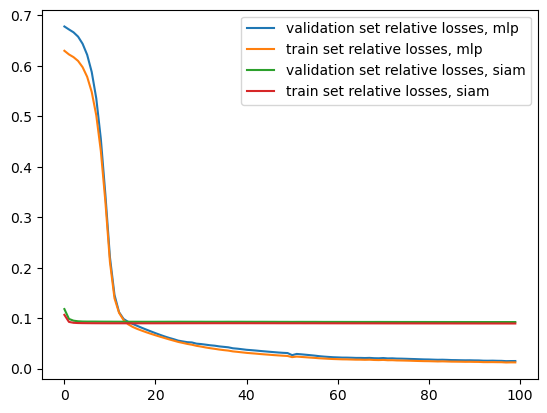

In [10]:
batch_size = 32
device = 'cuda:6'
config_file = 'configs/best-config-GAT.yml'
train_file = '/data/sam/terrain/data/norway/norway-1600-train.npz'
test_file = '/data/sam/terrain/data/norway/norway-1600-test.npz'
epoch_num = 100

train_data = np.load(train_file, allow_pickle=True)
test_data = np.load(test_file, allow_pickle=True)

train_dataset, train_node_features, train_edge_index = npz_to_dataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset, test_node_features, test_edge_index = npz_to_dataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

# Load model configs
with open(config_file, 'r') as file:
    model_configs = yaml.safe_load(file)

loss_data = []

for modelname in model_configs:
    config=model_configs[modelname]
    gnn = train_single_graph_baseline1(train_node_features, train_edge_index, train_dataloader, 
                                        test_node_features, test_edge_index, test_dataloader, 
                                        model_config = config, epochs=epoch_num, device=device,
                                        siamese=False, virtual_node=False, lr=0.0001)
    gnn = train_single_graph_baseline1(train_node_features, train_edge_index, train_dataloader, 
                                        test_node_features, test_edge_index, test_dataloader, 
                                        model_config = config, epochs=epoch_num, device=device,
                                        siamese=True, virtual_node=False, lr=0.0001)
    # out = train_mlp(train_node_features, train_edge_index, train_dataloader, 
    #                 test_node_features, test_edge_index, test_dataloader, 
    #                 model_config = config, gnn_model=gnn, epochs=500, device=device,
    #                 siamese=False, virtual_node=False, lr=0.0001)